# TTC Line 2 Arrival Time by Bohan

### Issues
1. Size of requests and responses did not match
2. Duplicates (based on requestid) were found after merging
3. There might be missing data (see last graph)

### Things to improve
1. 


### Things improved
1. Remove Trains that are outside of service time
2. Trains should not be at 2 stations at the same time
3. Switch station id for transfer stations

#### It makes basic explation on the simple data set

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import datetime; # datetime data

responses = pd.read_csv('responses.csv'); # import file
requests = pd.read_csv('requests.csv'); # import file

# merge two dataframes
df = pd.merge(left=responses, right=requests, left_on='requestid',
                  right_on='requestid');

#### Select Line 2 trains At Station

In [2]:
## Line 2 (BD) trains
trains_BD = df[df['subwayline'] == 'BD'];

# separate date and time
r_date = pd.to_datetime(trains_BD['request_date']);
trains_BD['date'] = r_date.dt.date;
trains_BD['time'] = r_date.dt.time;

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Take data from 6am to 1:30am everyday

In [3]:
# On weekdays and Saturdays, trains run from about 6 a.m. until 1:30 a.m. 
# On Sundays, they run from about 8 a.m. to 1:30 a.m.
# Take data from 6am to 1:30am everyday

trains_BD = trains_BD[(trains_BD['time']>=datetime.time( 6,0,0 )) |
                      (trains_BD['time']<=datetime.time( 1,30,0 )) ];

#### Find arrival time and separate date and time
#### And remove duplicates based on requestid

In [4]:
# AtStation
trains_BD_AtStation_old = trains_BD[trains_BD['train_message'] == 'AtStation'];
# remove duplicates
trains_BD_AtStation=trains_BD_AtStation_old.drop_duplicates(
        subset='requestid', keep='first', inplace=False);
        
print('Number of duplicates based on requestid = ',
      trains_BD_AtStation_old.shape[0]-trains_BD_AtStation.shape[0]);


Number of duplicates based on requestid =  1221


In [5]:
# Find trains arriving between 0 to 1 min exclusive
trains_BD_Delayed_old = trains_BD[(trains_BD['train_message'] == 'Delayed') &
                              (trains_BD['timint'] <1) &
                              (trains_BD['timint'] >0)];
                              
# remove duplicates in Delayed/Arriving
trains_BD_Delayed=trains_BD_Delayed_old.drop_duplicates(
        subset='requestid', keep='first', inplace=False);
        
print('Number of duplicates based on requestid = ',
      trains_BD_Delayed_old.shape[0]-trains_BD_Delayed.shape[0]);

print('Number of Delayed trains: ',len(trains_BD_Delayed.index) );                              


Number of duplicates based on requestid =  763
Number of Delayed trains:  773


In [6]:
trains_BD_Arriving_old = trains_BD[(trains_BD['train_message'] == 'Arriving') &
                              (trains_BD['timint'] <1) &
                              (trains_BD['timint'] >0)];
                               
# remove duplicates in Delayed/Arriving
trains_BD_Arriving=trains_BD_Arriving_old.drop_duplicates(
        subset='requestid', keep='first', inplace=False);
        
print('Number of duplicates based on requestid = ',
      trains_BD_Arriving_old.shape[0]-trains_BD_Arriving.shape[0]);
                               
print('Number of Arriving trains: ',len(trains_BD_Arriving.index) );


Number of duplicates based on requestid =  3448
Number of Arriving trains:  17884


#### Merge three dataframes and remove duplicates when trains are at station

In [7]:
## Concatenate three dataframes
merged = pd.concat([trains_BD_AtStation, trains_BD_Arriving], axis=0);
merged = pd.concat([merged, trains_BD_Delayed], axis=0);

# keep duplicates that indicates 'AtStation'
merged.drop(merged[merged.duplicated(subset='create_date', keep=False) & 
             (merged['train_message'] != 'AtStation')].index, axis=0, inplace=True)


#### Switch stationid and edit station_char, then sort

In [8]:
# Switch stationid
merged.loc[df['stationid'] == 9, 'stationid'] = 47;
merged.loc[df['stationid'] == 10, 'stationid'] = 48;
merged.loc[df['stationid'] == 22, 'stationid'] = 50;

# remove directionality in station_char
merged['station_char'] = merged['station_char'].str[:-1];

# sort
merged.sort_values(by=['date','trainid','time'], inplace=True);


### Plot behaviour of one train

In [9]:
# plotting
import matplotlib.pyplot as plt

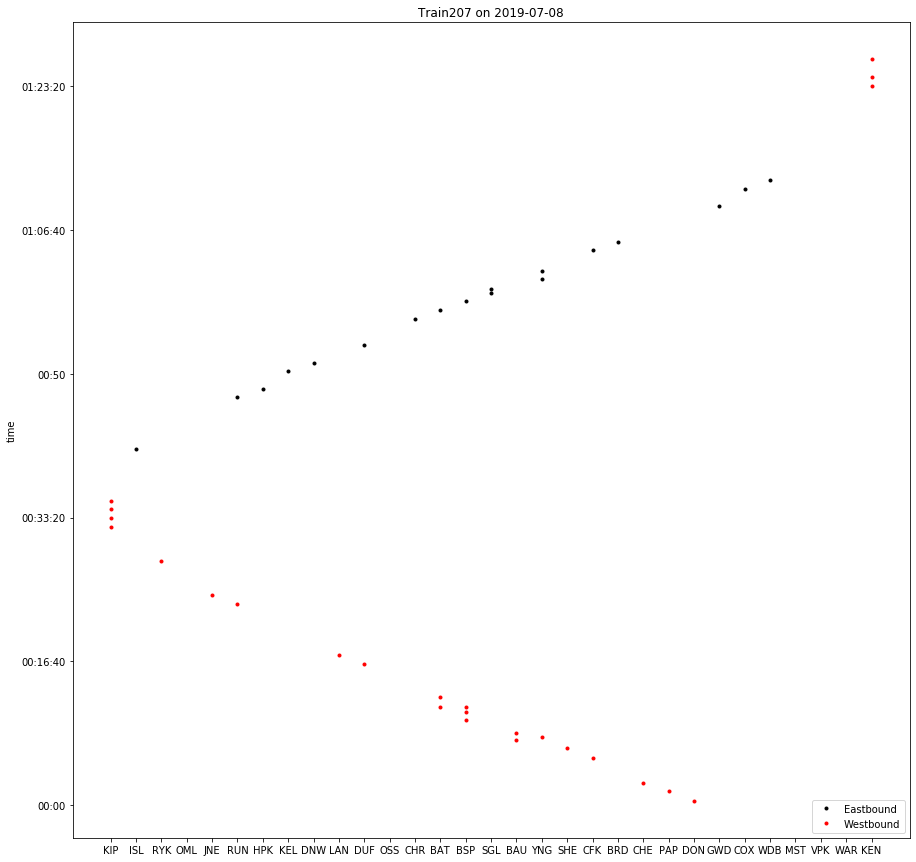

In [10]:
plt.figure(figsize=(15, 15))
train = 207;
day = datetime.date(2019,7,8);
plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['time'],'k.', label='Eastbound')

plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['time'],'r.', label='Westbound')
plt.xticks(merged['stationid'].unique(), merged['station_char'].unique())
plt.title('Train'+str(train)+' on '+str(day))
plt.legend(loc='lower right')
plt.show()

#### Comments:
1. The stationid of BSP2, SGL2, YNG2 are mislabeled for Line 1
2. Clustering shows the delay or wait time at terminals or busy downtown area
3. This train only ran for 3 hours in the morning
4. Some stations were skipped (i.e. not being labeled as AtStation?)

#### A different train

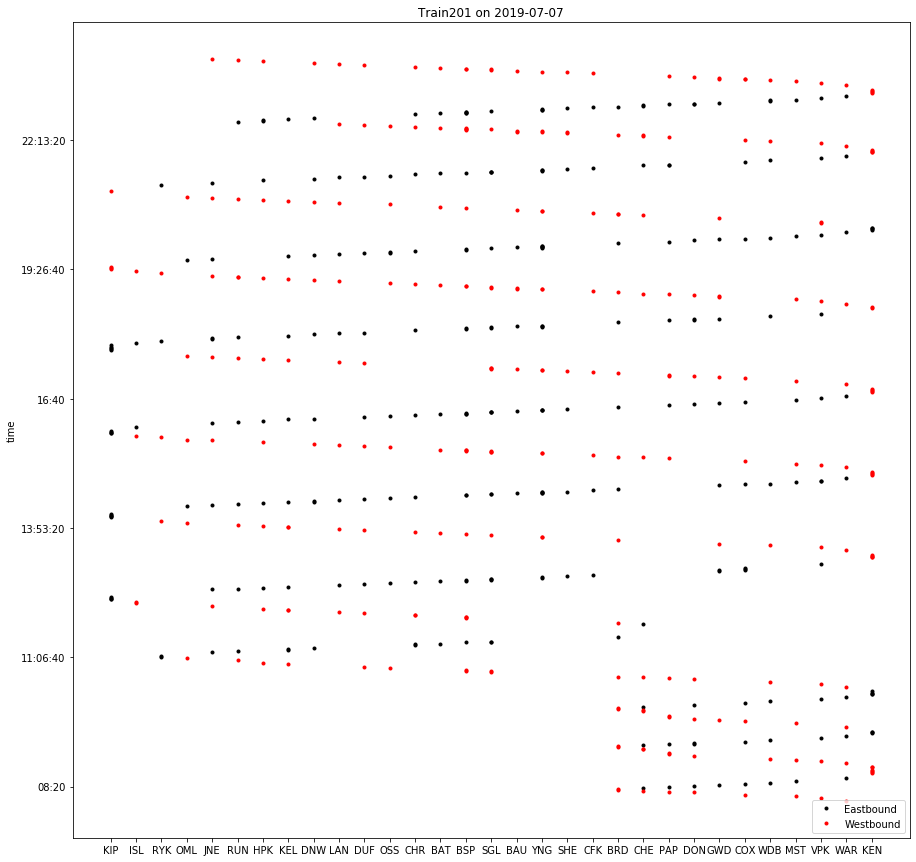

In [11]:
plt.figure(figsize=(15, 15))
train = 201;
day = datetime.date(2019,7,7);
plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'East') &
                (merged['date'] == day)]['time'],'k.', label='Eastbound')

plt.plot(merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['stationid'],
        merged[(merged['trainid'] == train) & (merged['traindirection'] == 'West') &
                (merged['date'] == day)]['time'],'r.', label='Westbound')
plt.xticks(merged['stationid'].unique(), merged['station_char'].unique())
plt.title('Train'+str(train)+' on '+str(day))
plt.legend(loc='lower right')
plt.show()